<a href="https://colab.research.google.com/github/Dewisrirahayu05/Aplikasi-Login/blob/main/Capstone_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

**Library Data Yang Penting**
* Keras -> 2.15.0
* Tensorflow -> 2.15.0

In [ ]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

In [27]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import zipfile
import shutil

from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!git clone https://github.com/hisyamfadhil/datasetcapstone.git

# **Preprocessing Dataset**


In [ ]:
os.listdir("/content/drive/MyDrive/dataset_tumor_otak")

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
labels[2]

In [ ]:
x_train = []
y_train = []
image_size = 150
max_images_per_class = 1500  # Set the limit for each class

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Process training data with a limit of 1500 images per class
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/dataset_tumor_otak', 'Training', i)
    image_count = 0  # Counter for the number of images processed for this label
    for j in tqdm(os.listdir(folderPath)):
        if image_count >= max_images_per_class:
            break  # Stop processing if the limit is reached

        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:  # Ensure the image was loaded successfully
            img = cv2.resize(img, (image_size, image_size))
            x_train.append(img)
            y_train.append(i)
            image_count += 1

# Process testing data with the same limit of 1500 images per class
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/dataset_tumor_otak', 'Testing', i)
    image_count = 0  # Reset counter for the test data
    for j in tqdm(os.listdir(folderPath)):
        if image_count >= max_images_per_class:
            break  # Stop processing if the limit is reached

        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:  # Ensure the image was loaded successfully
            img = cv2.resize(img, (image_size, image_size))
            x_train.append(img)
            y_train.append(i)
            image_count += 1

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

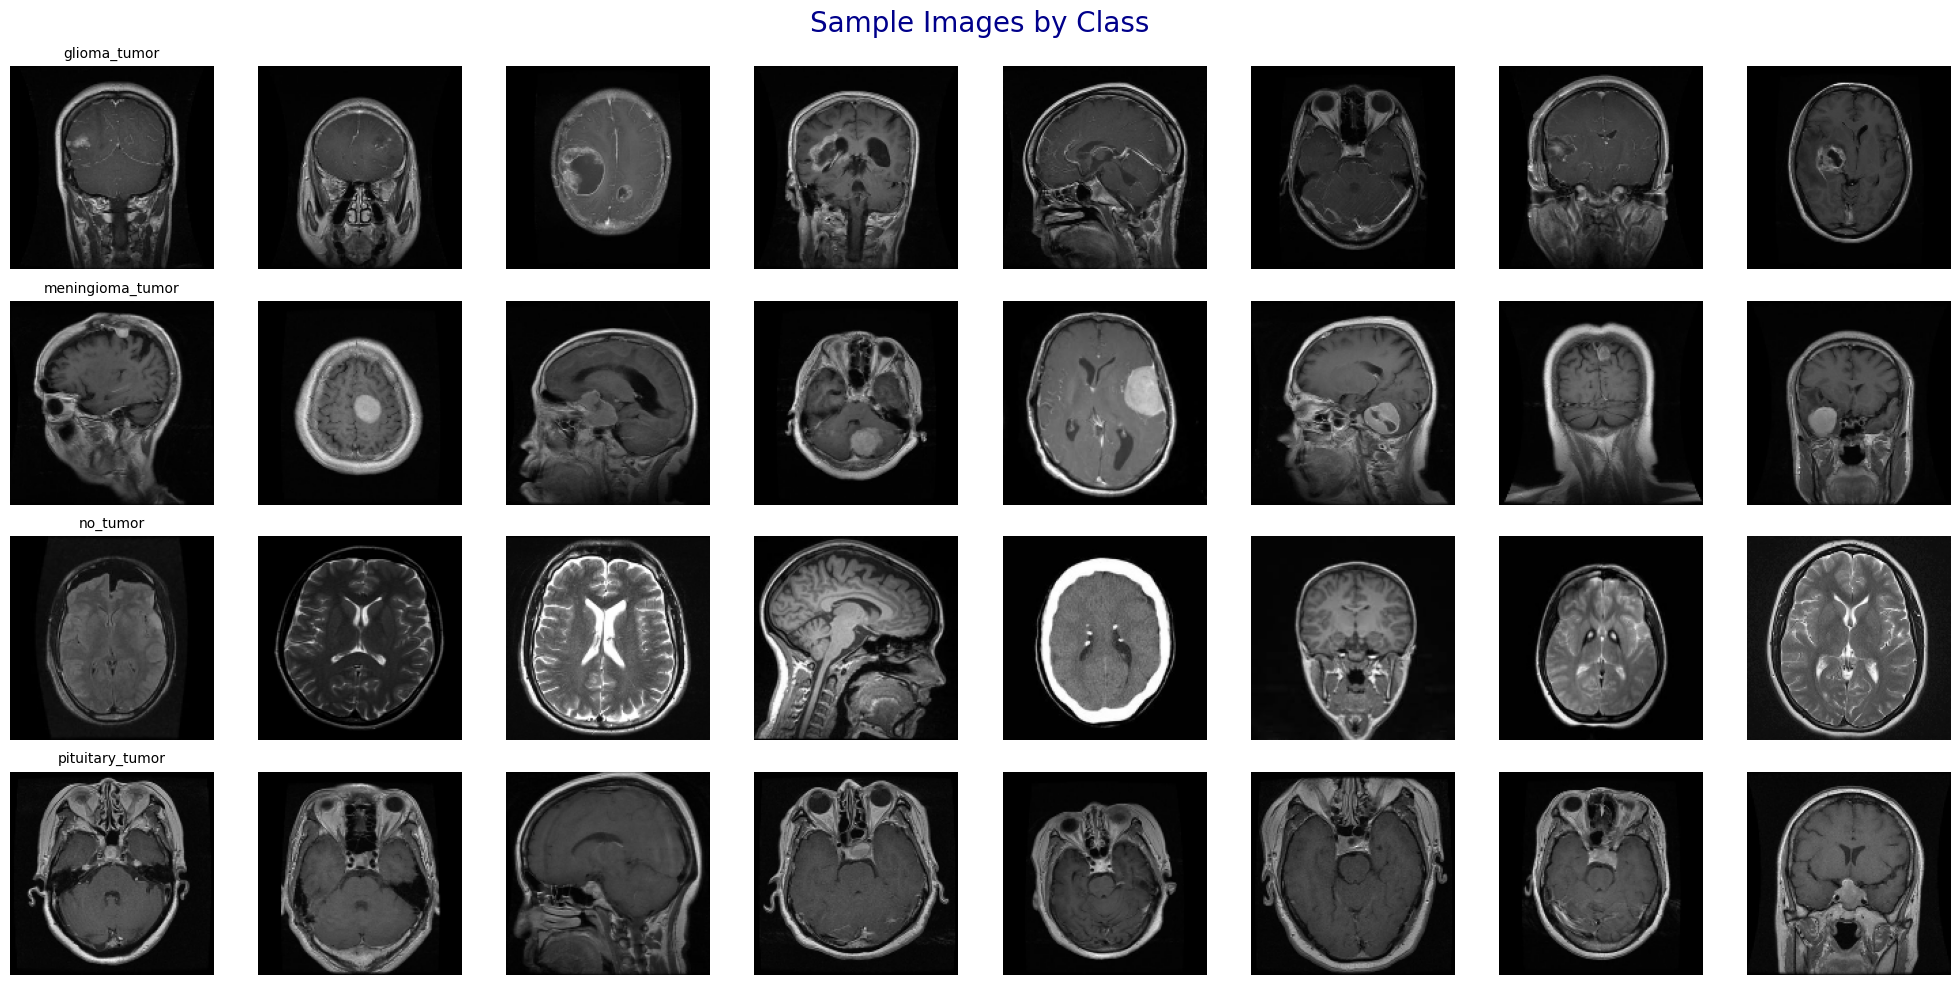

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'x_train' and 'y_train' are already processed and ready

# Display sample images based on their class
def display_sample_images_by_class(x_train, y_train, labels):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # Adjust number of columns for clarity
    fig.suptitle('Sample Images by Class', fontsize=20, color='darkblue')

    for i, label in enumerate(labels):
        images = x_train[np.array(y_train) == label][:8]  # Select first 8 images of each class
        for j, img in enumerate(images):
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(label if j == 0 else "", fontsize=10)

    plt.tight_layout()
    plt.show()

# Define the labels for visualization
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Call the visualization function
display_sample_images_by_class(x_train, y_train, labels)

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=101)

In [ ]:
x_train.shape

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)
x_train.shape

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Transfer Learning**

In [40]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

# **Arsitektur Convolutional Neural Network**

In [ ]:
# Define the model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Dropout layer for regularization
model.add(Dropout(0.5))

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(Dense(4, activation='softmax'))  # 4 classes: glioma, meningioma, notumor, pituitary

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Membuat model CNN
model = Sequential()

# Layer Konvolusi 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Konvolusi 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Konvolusi 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(4, activation='softmax'))  # 4 kelas output

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [43]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

tensorboard = TensorBoard(log_dir= 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor= 'val_accuracy', factor= 0.3, patience= 2, min_delta= 0.001,
                              mode='auto',verbose=1)

# **Training The Model**

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=8, verbose=1, batch_size=32,
                          callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/8
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6120 - loss: 11.9744
Epoch 1: val_accuracy improved from -inf to 0.81979, saving model to effnet.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.6124 - loss: 11.9445 - val_accuracy: 0.8198 - val_loss: 0.4883 - learning_rate: 0.0010
Epoch 2/8
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8273 - loss: 0.4698
Epoch 2: val_accuracy improved from 0.81979 to 0.88796, saving model to effnet.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.8273 - loss: 0.4697 - val_accuracy: 0.8880 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 3/8
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8895 - loss: 0.2964
Epoch 3: val_accuracy improved from 0.88796 to 0.91970, saving model to effnet.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.8895 - loss: 0.2964 - val_accuracy: 0.9197 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 4/8
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9175

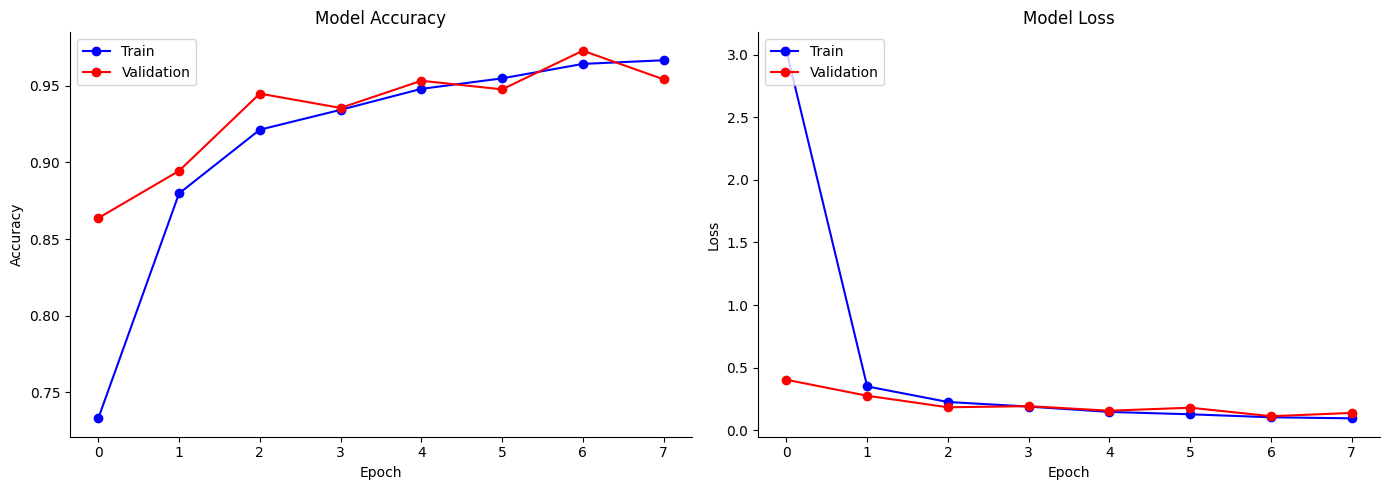

In [21]:
epochs = [i for i in range(len(history.history['accuracy']))]

# Membuat figure dan axes dengan hanya dua subplot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy values
ax[0].plot(epochs, history.history['accuracy'], label='Train', color='blue', marker='o', markerfacecolor='blue')
ax[0].plot(epochs, history.history['val_accuracy'], label='Validation', color='red', marker='o', markerfacecolor='red')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')
sns.despine(ax=ax[0])

# Plot training loss values
ax[1].plot(epochs, history.history['loss'], label='Train', color='blue', marker='o', markerfacecolor='blue')
ax[1].plot(epochs, history.history['val_loss'], label='Validation', color='red', marker='o', markerfacecolor='red')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')
sns.despine(ax=ax[1])

# Menampilkan figure
plt.tight_layout()
plt.show()

# **Prediction**

In [22]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 397ms/step


# **Evaluation**

# **Testing**

In [ ]:
# Assuming the labels are the following
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Convert one-hot encoded labels back to integer class indices if necessary
# Use `np.argmax` only if `y_test` is one-hot encoded
if len(y_test.shape) > 1:  # Check if y_test is one-hot encoded
    true_classes = np.argmax(y_test, axis=1)
else:
    true_classes = y_test  # Use directly if already in integer format

# Predict classes for the test set
predicted_classes = np.argmax(model.predict(x_test), axis=1)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import load_img

img_path = '/content/drive/MyDrive/dataset_tumor_otak/Testing/glioma_tumor/image(41).jpg'  # Replace with the actual path
img_array = img_to_array(img)  # Convert to a NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array /= 255.0

# Tampilkan gambar yang diuji
plt.imshow(load_img(img_path, target_size=(150, 150)))
plt.title("Gambar Input")
plt.axis('off')
plt.show()


In [25]:
# Melakukan prediksi
predictions = model.predict(img_array)

# Menggunakan softmax untuk mendapatkan probabilitas
score = tf.nn.softmax(predictions[0])

# Menentukan label kelas dengan probabilitas tertinggi
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
predicted_class = labels[np.argmax(score)]  # Kelas yang diprediksi
confidence = 100 * np.max(score)  # Tingkat kepercayaan model

# Menampilkan hasil prediksi
print(f"Gambar ini kemungkinan besar adalah '{predicted_class}' dengan tingkat kepercayaan {confidence:.2f}%.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Gambar ini kemungkinan besar adalah 'no_tumor' dengan tingkat kepercayaan 45.92%.
